In [1]:
!pip install --upgrade tensorflow tensorflow_probability

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 70.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow_probability
    Found existing installation: tensorflow-probability 0.22.0
    Uninstalling tensorflow-probability-0.22.0:
      Successfully uninstalled tensorflow-probability-0.22.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import moviepy
import cv2
import math
import tensorflow as tf
from IPython.display import clear_output
import tensorflow_probability as tfp
import time

gpu_available = tf.config.list_physical_devices('GPU')

if gpu_available:
    print("GPU is available!")
    # Additional GPU-related information
    gpu_info = !nvidia-smi
    print(gpu_info)
else:
    print("No GPU available. Switch to a GPU runtime in Colab.")

!nvdia-smi

GPU is available!
['Mon Jan 29 00:55:56 2024       ', '+---------------------------------------------------------------------------------------+', '| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |', '|-----------------------------------------+----------------------+----------------------+', '| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |', '| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |', '|                                         |                      |               MIG M. |', '|=========================================+======================+======================|', '|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |', '| N/A   36C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |', '|                                         |                      |                  N/A |', '+--------------

In [3]:
fps = 20
train_files = range(0, 5)
unlabeled_files = range(5, 10)
frames_number=1200
fps_visual = 30

ml_path="/content/drive/MyDrive/Learning/ml/"
root_path = f"{ml_path}/calib"

In [4]:
for x in train_files:
  !wget https://raw.githubusercontent.com/commaai/calib_challenge/main/labeled/{x}.txt -O {x}.txt
  !wget https://raw.githubusercontent.com/commaai/calib_challenge/main/labeled/{x}.hevc -O {x}.hevc

for x in unlabeled_files:
  !wget https://raw.githubusercontent.com/commaai/calib_challenge/main/unlabeled/{x}.hevc -O {x}.hevc

--2024-01-29 00:55:56--  https://raw.githubusercontent.com/commaai/calib_challenge/main/labeled/0.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60000 (59K) [text/plain]
Saving to: ‘0.txt’

0.txt               100%[===================>]  58.59K  --.-KB/s    in 0.006s  

2024-01-29 00:55:56 (9.54 MB/s) - ‘0.txt’ saved [60000/60000]

--2024-01-29 00:55:56--  https://raw.githubusercontent.com/commaai/calib_challenge/main/labeled/0.hevc
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37457546 (36M) [application/octet-stream]
Savi

In [5]:
df_list = [
    pd.read_csv(f'{x}.txt', header=None, delimiter=' ')
    for x in train_files
]

1200

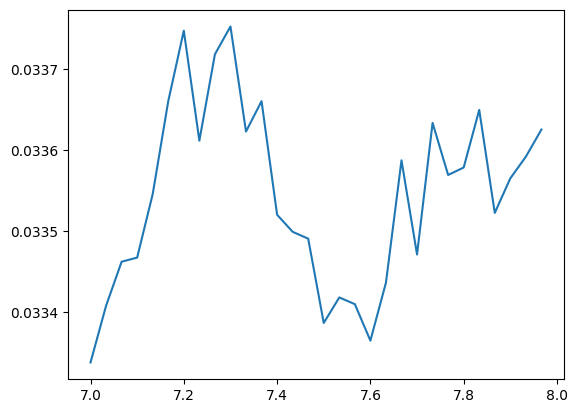

In [6]:
np.arange(5, 10)


st = 7*fps_visual
en = 8*fps_visual

# st = 100
# en = 101

# st=int(0.7 * frames_number)
# st = 0
# en=frames_number


# print(np.arange(40, 200).shape)
# print(df_list[0][0][40:200].shape)
plt.plot(np.arange(st, en)/fps_visual, df_list[0][0][st:en])
len(df_list[0][0])

In [7]:
def gaussian_smooth(flow, sigma=1.5):
    kernel_size = int(6 * sigma + 1)
    kernel_size = kernel_size + 1 if kernel_size % 2 == 0 else kernel_size
    return cv2.GaussianBlur(flow, (kernel_size, kernel_size), sigma)


def draw_flow_vecs(flow):
  flow_norm = flow / np.linalg.norm(flow, axis = 2)[..., np.newaxis]
  qx = []
  qy = []
  qvx = []
  qvy = []

  h, w, _ = flow.shape

  for i in range(0, h, 10):
    for j in range(0, w, 10):
      # flow_vec = 50 * flow_norm[i][j]
      flow_vec = 5 * flow[i][j]

      if np.linalg.norm(flow_vec) == 0:
        continue

      if np.linalg.norm(flow_vec) > 1:
        # v = 30 * flow_vec / np.linalg.norm(flow_vec)
        v = flow_vec
        qx.append(j)
        qy.append(i)
        qvx.append(v[0])
        qvy.append(v[1])

  plt.quiver(qx, qy, qvx, qvy, color='red', angles='xy', scale_units='xy', scale=1)

def get_frame_flow_n_ds(n, data_set=0, p1=0.5, p2=3, p3=15, p4=3, p5=5, p6=1.2, p7=0):

  global __frame_index
  global __data_set

  __frame_index = n
  __data_set = data_set

  file_name = f"{data_set}.hevc"
  print("Reading file", file_name)
  cap = cv2.VideoCapture(file_name)

  for i in range(n):
    cap.read()

  ret, frame1 = cap.read()
  ret, frame2 = cap.read()

  cap.release()

  gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
  gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

  # flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
  flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, p1, p2, p3, p4, p5, p6, p7)

  # flow = gaussian_smooth(flow)
  # flow = cv2.medianBlur(flow, 5)

  return (frame2, flow)

def get_frame_flow_n(n, p1=0.5, p2=3, p3=15, p4=3, p5=5, p6=1.2, p7=0):
  return get_frame_flow_n_ds(n, data_set=0, p1=0.5, p2=3, p3=15, p4=3, p5=5, p6=1.2, p7=0)

def print_optical_flow(n, data_set, p1, p2, p3, p4, p5, p6, p7):

  (frame2, flow) = get_frame_flow_n_ds(n, data_set, p1, p2, p3, p4, p5, p6, p7)

  plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
  draw_flow_vecs(flow)

  plt.show()

def get_sample_pixel_coordinate(data_set, frame_index):
  if data_set < len(df_list):
      o_x = df_list[data_set][1][frame_index]
      o_y = df_list[data_set][0][frame_index]

      if not math.isnan(o_x) and not math.isnan(o_y):
        o_x = int( 910 * math.sin(o_x) + 1164/2)
        o_y = int(-910 * math.sin(o_y) +  874/2)

        return (o_x, o_y)

  return (None, None)

__frame_index, __data_set = None, None

Reading file 1.hevc
Reading file 7.hevc


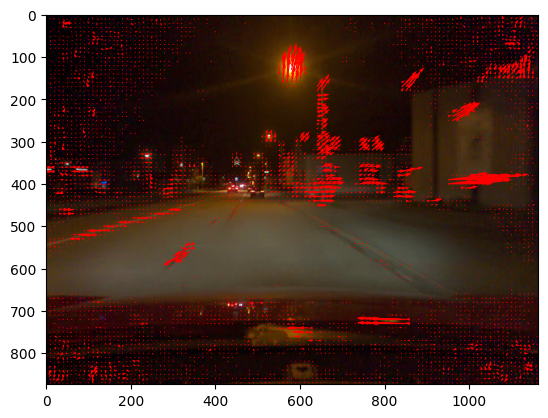

In [8]:
(frame2, flow) = get_frame_flow_n_ds(0, 1, 0.5, 3, 15, 3, 5, 1.2, 0)
print_optical_flow(100, 7, 0.5, 3, 15, 3, 5, 1.2, 0)

In [9]:
for i in range(1):
  print_optical_flow(i, 0.5, 3, 15, 3, 5, 1.2, 0)

TypeError: print_optical_flow() missing 1 required positional argument: 'p7'

In [10]:
def find_move_direction_by_flow_tf_v2(
    flow, show_report=False,
    shoud_filter_wrong_directed=True,
    iterations = 100000,
    direction_percentile = 30,
    stop_dot_value = 0.95
    ):
  q = extract_flow_points_tf(flow)
  l = list_of_lines_tf(q)
  c = find_move_direction_by_lines_tf(l)
  # p = evaluate_accuracy(l, c)

  print(c)

  r = {
    "iterations": 1,
    # "p": p,
    "c": c,
    "q": q
  }

  if show_report:
    draw_image(r)

  if shoud_filter_wrong_directed:
    q = filter_wrong_directed(q, c, direction_percentile)

  l = list_of_lines_tf(q)
  c = find_move_direction_by_lines_tf(l)
  p = evaluate_accuracy(l, c)

  r = {
    "iterations": 2,
    # "p": p,
    "c": c,
    "q": q
  }

  if show_report:
    draw_image(r)

  for i in range(iterations):

    # if (i + 1) % 10 == 0:
    #   clear_output(wait=True)

    # q = filter_accuracy(q, p)
    q = filter_wrong_directed(q, c, direction_percentile)
    thr = q["thr"]
    l = list_of_lines_tf(q)
    c = find_move_direction_by_lines_tf(l)
    p = evaluate_accuracy(l, c)

    # print("p_90", p["p_90"], "iteration = ", i)

    r = {
      "iterations": i + 1,
      # "p": p,
      "c": c,
      "q": q
    }

    if show_report:
      print()
      print("Iteration", i)

      print("p_20", p["p_20"])
      print("p_90", p["p_90"])

      plt.hist(p["accuracy"].numpy(), bins=50, color='skyblue', edgecolor='black', density=True)
      plt.show()

      draw_image(r)

    if thr > stop_dot_value:
      break

  return r

def find_move_direction_by_flow_tf_v3(
    flow, show_report=False,
    shoud_filter_wrong_directed=True,
    iterations = 100000,
    direction_percentile = 30,
    stop_dot_value = 0.95
    ):

  q = extract_flow_points_tf(flow)


  for i in range(iterations):
    l = list_of_lines_tf(q)
    c = find_move_direction_by_lines_tf(l)

    q_sub = filter_wrong_directed(q, c, direction_percentile)

    l_sub = list_of_lines_tf(q_sub)
    c_sub = find_move_direction_by_lines_tf(l_sub)

    q = filter_wrong_directed(q, c_sub, direction_percentile)

    thr = q["thr"]

    r = {
      "iterations": i + 1,
      "c": c,
      "q": q
    }

    if show_report:
      print()
      print("Iteration", i)

      p = evaluate_accuracy(l, c)

      print("p_20", p["p_20"])
      print("p_90", p["p_90"])

      plt.hist(p["accuracy"].numpy(), bins=50, color='skyblue', edgecolor='black', density=True)
      plt.show()

      draw_image(r)

    if thr > stop_dot_value:
      break

  return r

def find_move_direction_by_flow_tf_v4_not_stable(
    flow, show_report=False,
    shoud_filter_wrong_directed=True,
    iterations = 10,
    direction_percentile = 30,
    stop_dot_value = 0.95
    ):

  q = extract_flow_points_tf(flow)
  l = list_of_lines_tf(q)
  c = find_move_direction_by_lines_tf(l)

  for i in range(iterations):

    q_sub = filter_wrong_directed(q, c, 30)
    l = list_of_lines_tf(q_sub)
    c = find_move_direction_by_lines_tf(l)

    q_sub = filter_wrong_directed(q_sub, c, 99)
    l = list_of_lines_tf(q_sub)
    c = find_move_direction_by_lines_tf(l)

    # q = filter_wrong_directed(q, c_sub, direction_percentile)

    # thr = q["thr"]

    r = {
      "iterations": i + 1,
      "c": c,
      "q": q
    }

    if show_report:
      print()
      print("Iteration", i)

      p = evaluate_accuracy(l, c)

      print("p_20", p["p_20"])
      print("p_90", p["p_90"])

      plt.hist(p["accuracy"].numpy(), bins=50, color='skyblue', edgecolor='black', density=True)
      plt.show()

      draw_image(r)

    # if thr > stop_dot_value:
    #   break

  return r

In [70]:
def vector_len(v_x, v_y):
    return tf.sqrt(v_x*v_x + v_y*v_y)

def vector_normalize(v_x, v_y):
  v_len = vector_len(v_x, v_y)
  return (v_x/v_len, v_y/v_len)

def filter_small_vectors_tf(qx, qy, qvx, qvy):
  vector_length = vector_len(qvx, qvy)

  print("Vector length histogram")
  threshold = tfp.stats.percentile(vector_length, 50.0).numpy()
  print("Vector length p_50", threshold)

  indices = tf.where(vector_length > threshold)

  qx = tf.gather_nd(qx, indices)
  qy = tf.gather_nd(qy, indices)
  qvx = tf.gather_nd(qvx, indices)
  qvy = tf.gather_nd(qvy, indices)

  return (qx, qy, qvx, qvy)

def extract_flow_points_tf(flow):
  h, w, _ = flow.shape

  flow_tf = tf.constant(flow, dtype=tf.float64)
  qy, qx = tf.meshgrid(tf.range(h), tf.range(w), indexing='ij')

  qx = tf.cast(tf.reshape(qx, (-1, )), dtype = tf.float64)
  qy = tf.cast(tf.reshape(qy, (-1, )), dtype = tf.float64)
  flattened_flow = tf.reshape(flow_tf, [-1, tf.shape(flow_tf)[-1]])
  qvx = flattened_flow[:, 0]
  qvy = flattened_flow[:, 1]

  # qvx = qvx * qvx * tf.math.sign(qvx)
  # qvy = qvy * qvy * tf.math.sign(qvy)

  # qvx = tf.math.log(tf.math.abs(qvx) + 1.00) * tf.math.sign(qvx)
  # qvy = tf.math.log(tf.math.abs(qvy) + 1.00) * tf.math.sign(qvy)

  # qx, qy, qvx, qvy = filter_small_vectors_tf(qx, qy, qvx, qvy)
  # qvx, qvy = vector_normalize(qvx, qvy)

  return {
      "qx": qx,
      "qy": qy,
      "qvx": qvx,
      "qvy": qvy
  }

def list_of_lines_tf(q):
  l_a =  q["qvy"]
  l_b = -q["qvx"]
  l_c = -(l_a * q["qx"] + l_b * q["qy"]  )

  return {
      "l_a": l_a,
      "l_b": l_b,
      "l_c": l_c
  }


def find_move_direction_by_lines_tf(l):

  cnt = np.linalg.solve(
    np.array([
        [tf.math.reduce_sum((l["l_a"] * l["l_a"])), tf.math.reduce_sum((l["l_a"] * l["l_b"]))],
        [tf.math.reduce_sum((l["l_a"] * l["l_b"])), tf.math.reduce_sum((l["l_b"] * l["l_b"]))],
    ]), np.array(
        [-tf.math.reduce_sum((l["l_a"] * l["l_c"])), -tf.math.reduce_sum((l["l_b"] * l["l_c"]))]
    )
  )

  return {
      "c_x": cnt[0],
      "c_y": cnt[1]
  }

def evaluate_accuracy(l, c):
  accuracy = l["l_a"] * c["c_x"] + l["l_b"] * c["c_y"] + l ["l_c"]
  accuracy = tf.abs(accuracy)

  accuracy_sorted = tf.sort(accuracy)

  return {
      "accuracy": accuracy,
      "p_20": tfp.stats.percentile(accuracy, 20.0).numpy(),
      "p_90": tfp.stats.percentile(accuracy, 90.0).numpy()
  }

  return

def filter_accuracy(q, p):
  accuracy_index = tf.where((p["accuracy"]) < p["p_20"])

  return {
      "qx": tf.gather_nd(q["qx"], accuracy_index),
      "qy": tf.gather_nd(q["qy"], accuracy_index),
      "qvx": tf.gather_nd(q["qvx"], accuracy_index),
      "qvy": tf.gather_nd(q["qvy"], accuracy_index)
  }


def filter_wrong_directed(q, c, percentile):

  v1_x, v1_y = vector_normalize(q["qvx"], q["qvy"])
  # v2_x, v2_y = vector_normalize((q["qx"] - c["c_x"]), (q["qy"] - c["c_y"]))
  v2_x, v2_y = ((q["qx"] - c["c_x"]), (q["qy"] - c["c_y"]))

  v_len = vector_len(v2_x, v2_y)

  v2_x = v2_x / v_len
  v2_y = v2_y / v_len

  direction = (v1_x * v2_x + v1_y * v2_y)

  # threshold = math.cos(math.pi / 4)
  # print("angle threshold = math.pi / 4 = ", math.pi / 4)

  direction = tf.boolean_mask(direction, tf.math.is_finite(direction))

  threshold = tfp.stats.percentile(direction, percentile).numpy()
  # print(f"angle p_{percentile} (threshold)", threshold)
  # print("angle p_20", tfp.stats.percentile(direction, 20.0).numpy())
  # print("angle p_80", tfp.stats.percentile(direction, 80.0).numpy())

  if plot_debug_mode:
    print("Direction histogram")
    plt.hist(direction.numpy(), bins=50, color='skyblue', edgecolor='black', density=True)
    plt.show()

  accuracy_index = tf.where(direction > threshold)
  # accuracy_index = tf.where(tf.logical_or(direction > threshold, v_len < 50))
  return {
      "thr": threshold,
      "qx": tf.gather_nd(q["qx"], accuracy_index),
      "qy": tf.gather_nd(q["qy"], accuracy_index),
      "qvx": tf.gather_nd(q["qvx"], accuracy_index),
      "qvy": tf.gather_nd(q["qvy"], accuracy_index)
  }

def draw_flow_vecs_tf(q):
  plt.quiver(q["qx"], q["qy"], 20 * q["qvx"], 20 * q["qvy"], color='red', angles='xy', scale_units='xy', scale=1)



def draw_image(r, draw_optical_flow=True, frame = None):
  if frame is None:
    frame = frame2

  cnt = r["c"]

  print("Iterations executed: ", r["iterations"])
  print(cnt["c_x"], cnt["c_y"])

  plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  if draw_optical_flow:
    draw_flow_vecs_tf(r["q"])

  o_x, o_y = get_sample_pixel_coordinate(__data_set, __frame_index)

  if o_x is not None and o_y is not None:
    plt.quiver(o_x, o_y, 0, -50, color='yellow', angles='xy', scale_units='xy', scale=1)

  plt.quiver(cnt["c_x"], cnt["c_y"], 0, -200, color='white', angles='xy', scale_units='xy', scale=1)

  plt.show()



def find_move_direction_by_flow_tf(
    flow, show_report=False,
    shoud_filter_wrong_directed=True,
    iterations = 100000,
    direction_percentile = 30,
    stop_dot_value = 0.95
    ):
  # V2 used to calculate prediction
  # V3 can be used to compare with v2 accuracy
  return find_move_direction_by_flow_tf_v2(
    flow, show_report,
    shoud_filter_wrong_directed,
    iterations,
    direction_percentile,
    stop_dot_value
  )

# Initial strategy:
# - filter threlength threshold
# - pi/4 onlt first time
# 20 percentile

# Initial strategy:
# - filter thre length threshold (normalize)
# - pi/4 onlt every step time
# 20 percentile - no


# frame2, flow = get_frame_flow_n_ds(1100, 0)
# frame2, flow = get_frame_flow_n_ds(150, 5)
# frame2, flow = get_frame_flow_n_ds(429 , 5)
# frame2, flow = get_frame_flow_n_ds(0, 6)
# frame2, flow = get_frame_flow_n_ds(0, 5)

frame2, flow = get_frame_flow_n_ds(0, 0)

# frame2, flow = get_frame_flow_n_ds(2 * fps_visual, 0)



plot_debug_mode=False

r = find_move_direction_by_flow_tf(
    flow,
    show_report = True,
    direction_percentile = 30,
    # direction_percentile = 30,
    stop_dot_value = 0.99,
    )

draw_image(r, draw_optical_flow = True)
draw_image(r, draw_optical_flow = True)

# 180 605.6459560639142 403.130274319856
# 90 605.1666328003001 410.27392722962253
# 60 607.9862999721291 409.20061835922303
# 45 degree - 605.6459560639142 403.130274319856

# angle with 10 percentile on 10 iteration gives awesome result needs to try generate points for first video

# Todo try another option:
#
# - Take global average
# - find sub-set with certain percentile by angle
# - find avereage for sub-set
# - Reduce global by using percentile of sub-set average
#
# Same approach can be used to calibrate camers
#
# Video 6 is challenging

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
r = find_move_direction_by_flow_tf(
    flow,
    show_report = False,
    direction_percentile = 1,
    # direction_percentile = 30,
    stop_dot_value = 0.99,
    )

draw_image(r, draw_optical_flow = False)

In [ ]:
r = find_move_direction_by_flow_tf(
    flow,
    show_report = False,
    iteration = 100000,
    direction_percentile = 1,
    stop_dot_value = 0.98
    )

draw_image(r)

In [ ]:
import tensorflow as tf

def tf_cart_product(tensor1, tensor2):
  # Input tensors
  tensor1 = tf.constant([1, 2, 3], dtype=tf.float32)
  tensor2 = tf.constant([20, 30], dtype=tf.float32)

  # Create meshgrid
  indices1, indices2 = tf.meshgrid(tf.range(tf.size(tensor1)), tf.range(tf.size(tensor2)))

  indices1_flat = tf.reshape(indices1, [-1])
  indices2_flat = tf.reshape(indices2, [-1])
  # Gather elements using meshgrid indices
  cartesian_product = tf.stack([tf.gather(tensor1, indices1_flat), tf.gather(tensor2, indices2_flat)], axis=1)

  return cartesian_product

In [12]:
def smooth_data(data, n):
  result = np.copy(data)

  if n <= 1:
    return result

  for i in range(len(data)):
    arr_st = i - int(n /2)

    if arr_st < 0:
      arr_st = 0

    arr_end = arr_st + n

    if arr_end > len(data):
      arr_end = len(data)
      arr_st = arr_end - n

    if arr_st < 0:
      arr_st = 0

    if arr_st == arr_end:
      break

    result[i] = np.sum(data[arr_st: arr_end]) / (arr_end - arr_st)
  return result

def smooth_past_data(data):
  result = np.copy(data)

  for i in range(len(data)):
    result[i] = np.mean(data[0:i+1])

  return result

def sort_by_deviation(data, mean = None):
  if mean is None:
    mean = np.mean(data)

  deviation = (data - mean)
  deviation = deviation * deviation

  indices = np.argsort(deviation)
  sorted_data = data[indices]

  return sorted_data

def smooth_calib(data):
  result = np.copy(data)

  prev_data = sort_by_deviation(data[:100])
  result[:100] = np.mean(prev_data[:30])

  for i in range(101, len(data)):

    prev_data[-1] = data[i]
    prev_data = sort_by_deviation(prev_data)

    result[i] = np.mean(prev_data[:30])

  return result

def take_percentile_by_deviation(data, mean, percentile):
  sorted_data = sort_by_deviation(data, mean)

  arr_end = int(percentile * len(data) / 100) + 1

  return sorted_data[0:arr_end]


def smooth_calib_v1(data, percentile):
  result = np.copy(data)

  for i in range(len(data)):
    prev_data = data[0:i+1]

    closest_to_mean = take_percentile_by_deviation(prev_data, np.mean(data), percentile)

    result[i] = np.mean(closest_to_mean)

  return result

In [66]:
class VideoProcessor:
  def __init__(
      self,
      data_set,
      save_prediction = True,
      calculate_prediction = False,
      save_new_video = False,
      new_video_sufix = "",
      draw_direction_marker = True,
      draw_optical_flow = False,
      stop_on_frame = 10000,
      smooth_enabled = False,
      comma_marker=True
    ):
      self.data_set = data_set
      self.save_prediction = save_prediction
      self.save_new_video = save_new_video
      self.new_video_sufix = new_video_sufix
      self.draw_direction_marker = draw_direction_marker
      self.draw_optical_flow = draw_optical_flow
      self.stop_on_frame = stop_on_frame
      self.smooth_enabled = smooth_enabled
      self.comma_marker=comma_marker

      self.x_file_name = f"{root_path}/x_{data_set}_45.csv"
      self.y_file_name = f"{root_path}/y_{data_set}_45.csv"

      self.stored_prediction_x = None
      self.stored_prediction_y = None

      self.prediction_point = None
      self.r = None

      self.video_file = f"{data_set}.hevc"
      self.write_file = f"{root_path}/out-{data_set}{new_video_sufix}.mp4"
      self.out = None

      self.frame_index = 0

      self.prev_gray = None
      self.prev_flow = None

      self.x_cnt = [0]
      self.y_cnt = [0]
      self.p90_by_frame=[0]

      self.calculate_prediction = calculate_prediction
      self.calculate_prediction = self.calculate_prediction or save_prediction
      self.calculate_prediction = self.calculate_prediction or (save_new_video and draw_optical_flow)


  def do_prediction(self):
    gray = cv2.cvtColor(self.frame, cv2.COLOR_BGR2GRAY)
    flow = None

    if self.prev_gray is not None:
      flow = cv2.calcOpticalFlowFarneback(self.prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
      # if self.prev_flow is not None:
      #   flow = flow * 0.1 + self.prev_flow * 0.9

      # direction_percentile = 30,
      # # direction_percentile = 30,
      # stop_dot_value = 0.99,

      self.r = find_move_direction_by_flow_tf(
          flow,
          direction_percentile = 20,
          stop_dot_value = 0.99
          )
      cnt = self.r["c"]
      # p = r["p"]
      self.x_cnt.append(cnt["c_x"])
      self.y_cnt.append(cnt["c_y"])
      # self.p90_by_frame.append(p["p_90"])

      self.prediction_point = cnt

    self.prev_gray = gray
    self.prev_flow = flow
    self.prev_frame = self.frame

  def do_save_prediction(self):
    self.x_cnt[0] = self.x_cnt[1]
    self.y_cnt[0] = self.y_cnt[1]
    # self.p90_by_frame[0] = self.p90_by_frame[1]

    print("Writing to file", self.x_file_name)
    print("Writing to file", self.y_file_name)

    np.savetxt(self.x_file_name, np.asarray(self.x_cnt), delimiter=",")
    np.savetxt(self.y_file_name, np.asarray(self.y_cnt), delimiter=",")

  def load_stored_prediction(self):
    if self.prediction_point is None:
      if self.stored_prediction_x is None:
        self.stored_prediction_x = np.loadtxt(self.x_file_name, delimiter=",")

        if self.smooth_enabled:
          # self.stored_prediction_x  = smooth_data(self.stored_prediction_x, 50)
          # self.stored_prediction_x = smooth_past_data(self.stored_prediction_x)

          # self.stored_prediction_x = smooth_past_data(self.stored_prediction_x)
          self.stored_prediction_x = smooth_calib(self.stored_prediction_x)



      if self.stored_prediction_y is None:
        self.stored_prediction_y = np.loadtxt(self.y_file_name, delimiter=",")

        if self.smooth_enabled:
          # self.stored_prediction_y  = smooth_data(self.stored_prediction_y, 50)
          # self.stored_prediction_y = smooth_past_data(self.stored_prediction_y)
          # self.stored_prediction_y = smooth_past_data(self.stored_prediction_y)
          self.stored_prediction_y = smooth_calib(self.stored_prediction_y)


      self.prediction_point = {
          "c_x" : self.stored_prediction_x[self.frame_index],
          "c_y" : self.stored_prediction_y[self.frame_index]
      }
      print("Prediction point taken from cloud")
    else:
      print("Prediction point is calculated")

  def do_draw_markers(self):
    frame = self.frame

    self.load_stored_prediction()

    c_x = int(self.prediction_point["c_x"])
    c_y = int(self.prediction_point["c_y"])

    a = 20
    b = 10

    cv2.line(frame, (c_x - a, c_y), (c_x - b, c_y), (255, 255, 255), 4)
    cv2.line(frame, (c_x + a, c_y), (c_x + b, c_y), (255, 255, 255), 4)
    cv2.line(frame, (c_x, c_y - a), (c_x, c_y - b), (255, 255, 255), 4)
    cv2.line(frame, (c_x, c_y + a), (c_x, c_y + b), (255, 255, 255), 4)

    o_x, o_y = get_sample_pixel_coordinate(self.data_set, self.frame_index)

    print(self.data_set, self.frame_index)
    print(o_x, o_y)

    if self.comma_marker and o_x is not None and o_y is not None:
      cv2.line(frame, (o_x - a, o_y - a), (o_x - b, o_y - b), (255, 255, 255), 4)
      cv2.line(frame, (o_x - a, o_y + a), (o_x - b, o_y + b), (255, 255, 255), 4)
      cv2.line(frame, (o_x + a, o_y - a), (o_x + b, o_y - b), (255, 255, 255), 4)
      cv2.line(frame, (o_x + a, o_y + a), (o_x + b, o_y + b), (255, 255, 255), 4)

  def do_draw_optical_flow(self):
    if self.r is not None:
      q = self.r["q"]
      frame = self.frame

      qx = q["qx"]
      qy = q["qy"]
      qvx = q["qvx"]
      qvy = q["qvy"]

      for i in range(len(qx)):
        cv2.arrowedLine(frame, (int(qx[i]), int(qy[i])), (int(qx[i] + qvx[i]), int(qy[i] + qvy[i])), (255, 0, 0), 1)

  def process(self):

    temp_file = "out.mp4"

    start_time = time.time()

    cap = cv2.VideoCapture(self.video_file)

    width = int(cap.get(3))
    height = int(cap.get(4))
    fps = int(cap.get(5))

    out = None

    if self.save_new_video:
      fourcc = cv2.VideoWriter_fourcc(*'FMP4')
      out = cv2.VideoWriter(temp_file, fourcc, fps_visual, (width, height))

    while True:
      print()
      print("Reading...")
      print("Reding file", self.video_file)
      if out is not None:
        print("Writing file", self.write_file)

      ret, frame = cap.read()
      if not ret:
          break

      self.frame = frame

      print("Caclulating")

      self.prediction_point = None

      if self.calculate_prediction:
        self.do_prediction()

      if out is not None and self.frame_index > 0:
        if self.draw_optical_flow:
          self.do_draw_optical_flow()

        if self.draw_direction_marker:
          self.do_draw_markers()

        out.write(frame)

      clear_on = 20

      if (self.frame_index + 1) % clear_on == 0:
        clear_output(wait=True)

      if self.frame_index > 0:
        current_time_seconds = time.time()
        processing_time = (current_time_seconds - start_time)/60
        minutes_per_frame = processing_time / (self.frame_index + 1)
        max_fram = min(1200, self.stop_on_frame)
        total_estimated_time = int(max_fram * minutes_per_frame)

        print("Calculated", self.frame_index, "dataset = ", self.data_set)
        print("   ",
              "Remain time", int(total_estimated_time) - int(processing_time),
              "(m), Total time", int(total_estimated_time),
              "(m), Processing time", int(processing_time),
              "(m), Seconds per frame", (minutes_per_frame * 60), "(s)"
        )

      if (self.frame_index + 1) % clear_on == 0 and self.r is not None:
        draw_image(self.r, draw_optical_flow = False, frame=self.frame)

      if self.frame_index > self.stop_on_frame:
        break

      self.frame_index += 1

    global last_processed

    last_processed = (
        self.x_cnt, self.y_cnt
    )

    cap.release()
    if out is not None:
      out.release()

    print("out =", out)

    if self.save_prediction:
      self.do_save_prediction()
    !cp -f {temp_file} {self.write_file}

    print(self.frame_index)

last_processed = None


plot_debug_mode=False
for x in range(0, 10):
  VideoProcessor(
      x,
      calculate_prediction = False,
      save_prediction = False,
      save_new_video = True,
      draw_optical_flow = False,
      smooth_enabled = True,
      comma_marker=False
      # stop_on_frame = 120

  ).process()

print(last_processed)


# # Plot the NumPy array
# plt.imshow(frame)
# plt.show()

# print(ret, frame.shape)

Calculated 1199 dataset =  9
    Remain time 0 (m), Total time 0 (m), Processing time 0 (m), Seconds per frame 0.03671969970067342 (s)

Reading...
Reding file 9.hevc
Writing file /content/drive/MyDrive/Learning/ml//calib/out-9.mp4
out = < cv2.VideoWriter 0x7c0d85bdf230>
1200
([0], [0])


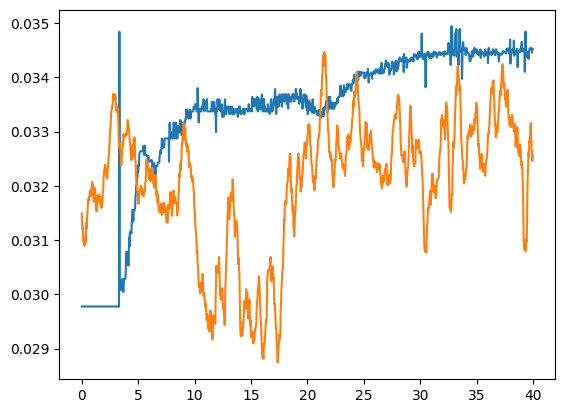

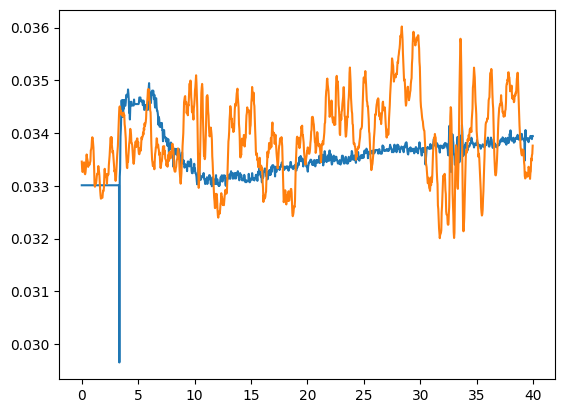

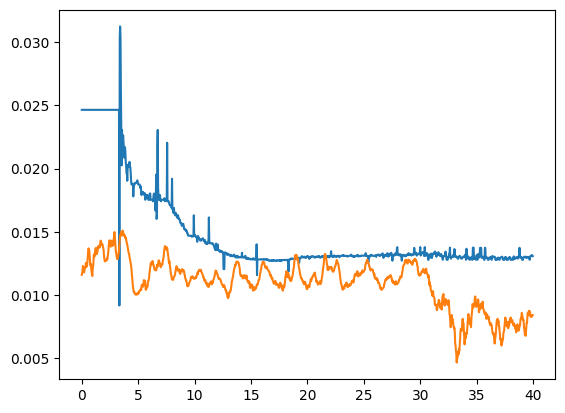

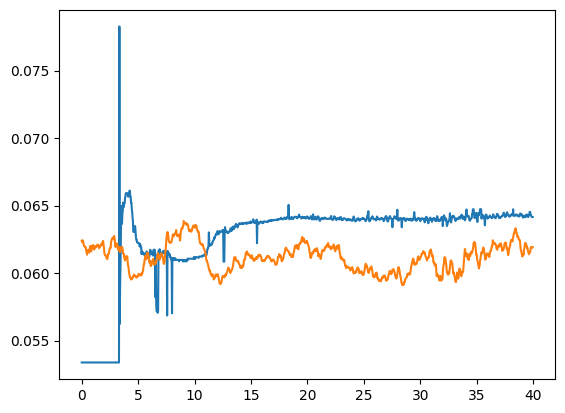

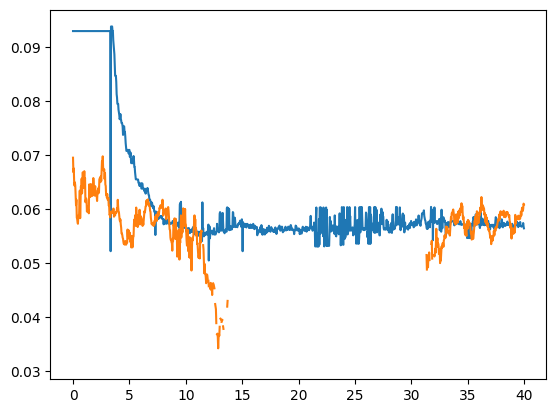

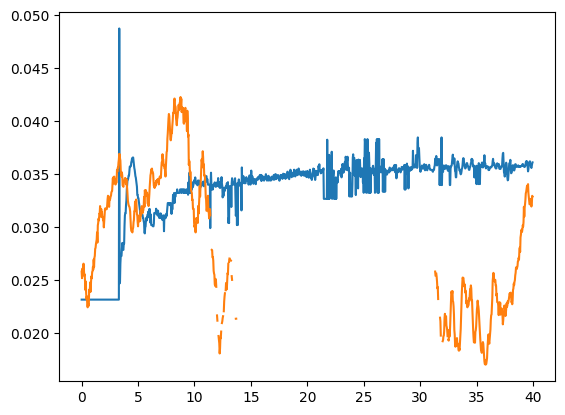

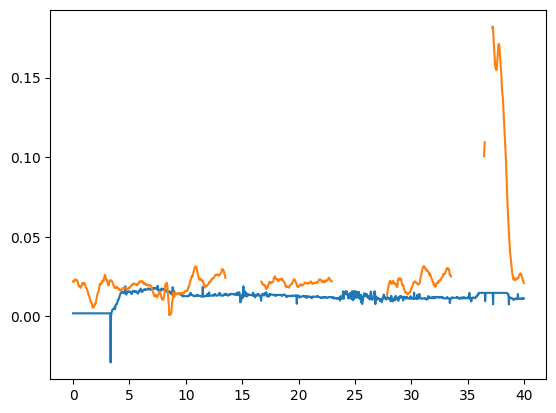

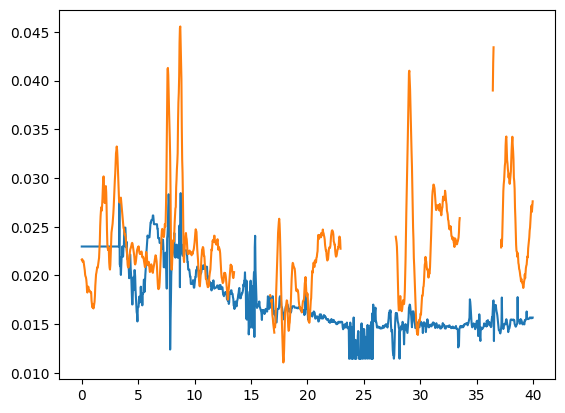

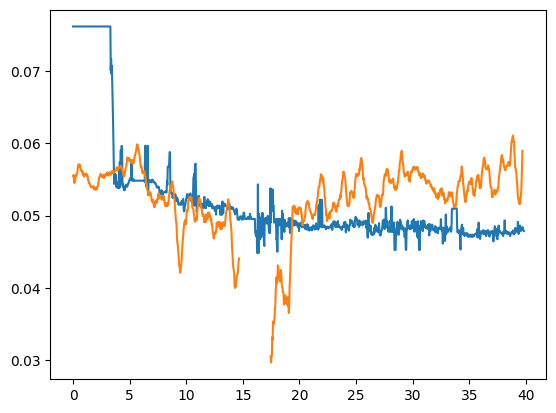

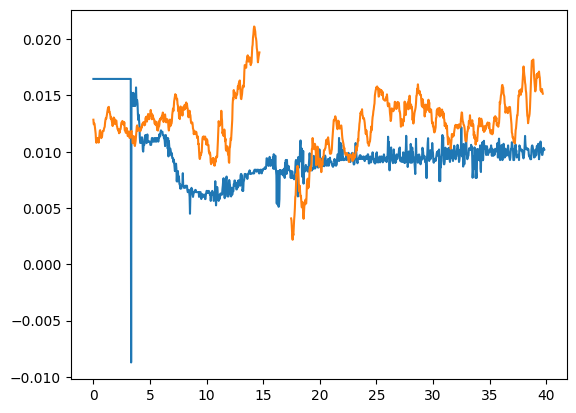

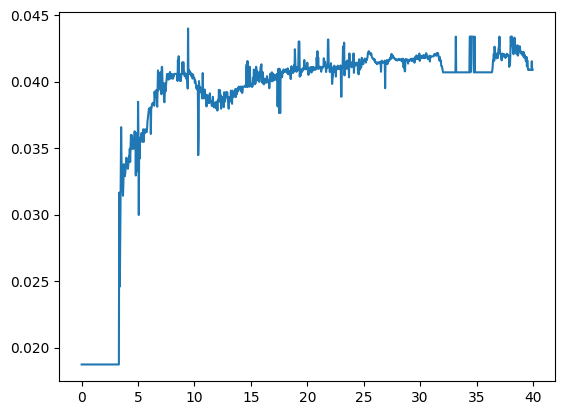

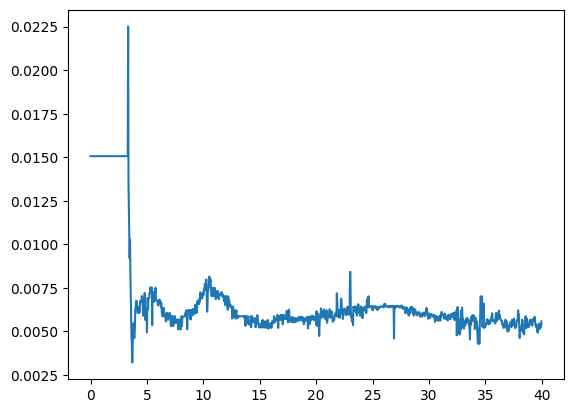

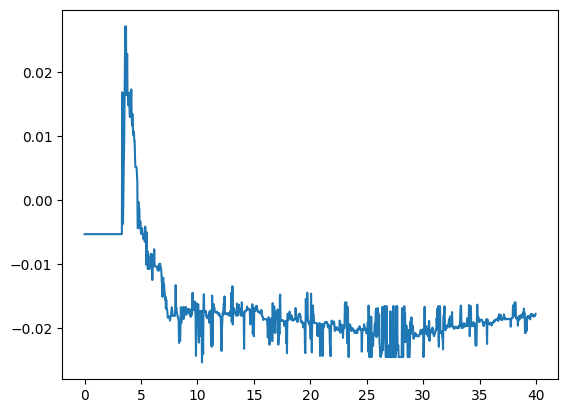

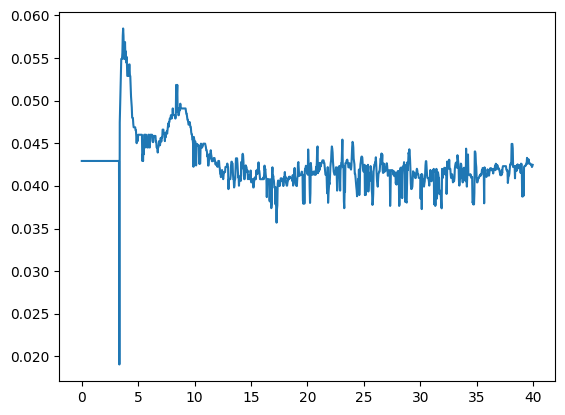

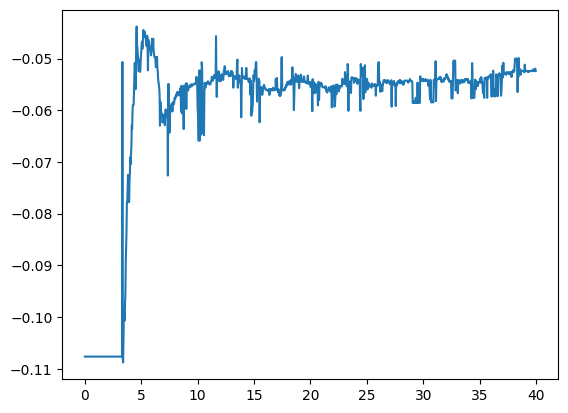

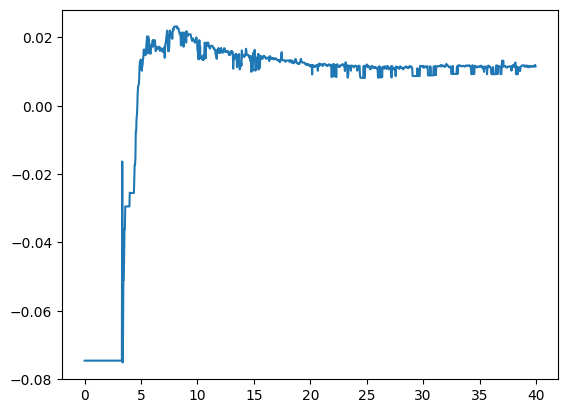

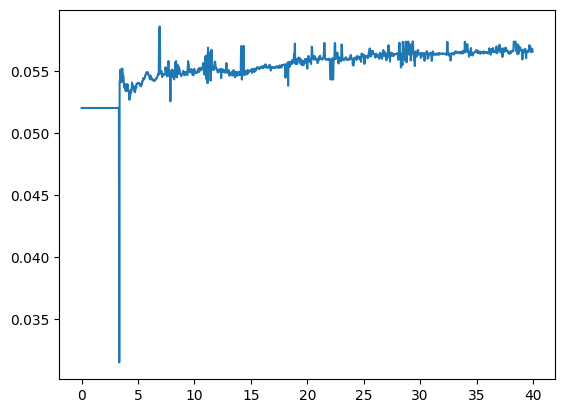

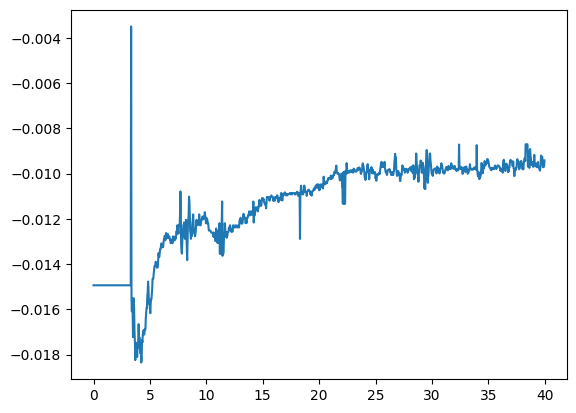

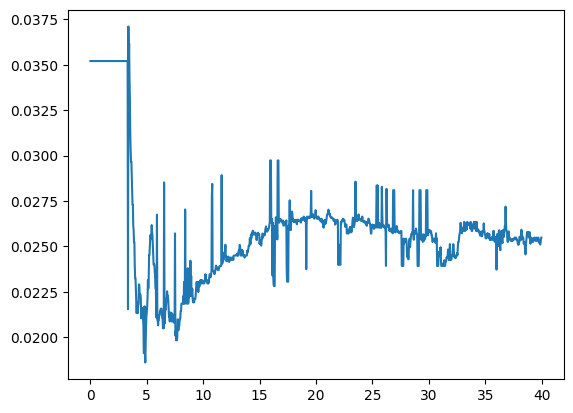

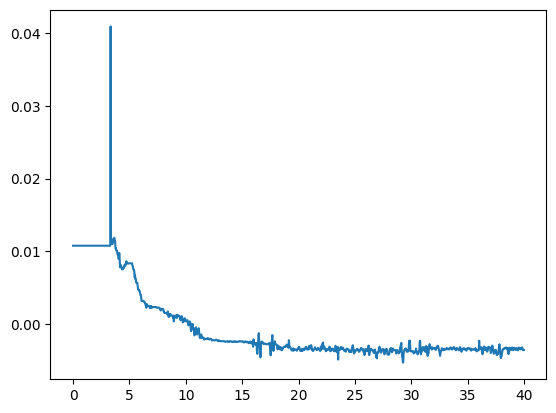

In [135]:
def build_x_axis(data_set, use_seconds):

  __en = en
  if(data_set < len(df_list)):
    __en = min(en, len(df_list[data_set][0]))

  result = np.arange(st, __en)

  if(use_seconds):
    result = result/fps_visual

  return result

def plot_prediction(
    axis,
    data_set,
    angle,
    smooth = 10,
    shift = 0,
    use_seconds=True,
    folder="calib"):
  file_path = f"{ml_path}/{folder}/{axis}_{data_set}_{angle}.csv"
  print("Loading dile:", file_path)
  prediction = np.loadtxt(file_path, delimiter=",")

  prediction = np.array(prediction[st:en])

  # image size: 1164, 910
  # 910 is pixel focal len of camera
  if(axis == "x"):
    prediction = np.arctan((prediction - 1164/2) / 910)
  else:
    prediction = -np.arctan((prediction - 874/2) / 910)

  if smooth != 0:
    # prediction = smooth_data(prediction, smooth)
    # prediction = smooth_past_data(prediction)
    prediction = smooth_calib(prediction)

  prediction += shift

  plt.plot(build_x_axis(data_set, use_seconds), prediction)

def plot_source(axis, data_set, shift = 0, use_seconds=True):
  if(data_set >= len(df_list)):
    return

  axis_index = 1 if axis == "x" else 0

  plt.plot(build_x_axis(data_set, use_seconds), df_list[data_set][axis_index][st:en] + shift)

def plot_converted(axis, data_set, shift = 0, use_seconds=True):
  file_name = f"{ml_path}/calib_smooth/{data_set}.txt"
  data = pd.read_csv(file_name, header=None, delimiter=' ')

  axis_index = 1 if axis == "x" else 0

  plt.plot(build_x_axis(data_set, use_seconds), data[axis_index][st:en] + shift)


st = 0
en = frames_number

# st = 0
# en = 4

# st = 900
# en = 1200

def plot():
  __smooth = 50
  __use_seconds = True


  for data_set in range(0, 10):
    for axis in ["x", "y"]:
    # for axis in ["x"]:

      # plot_prediction(axis, data_set, "old", smooth = __smooth, use_seconds=__use_seconds, shift = 0.0)
      # plot_prediction(axis, data_set, "180", smooth = __smooth, use_seconds=__use_seconds, shift = 0.0)
      # plot_prediction(axis, data_set, 90,    smooth = __smooth, use_seconds=__use_seconds, shift = 0.0)
      # plot_prediction(axis, data_set, 60,    smooth = __smooth, use_seconds=__use_seconds, shift = 0.0)
      # plot_prediction(axis, data_set, 45,    smooth = 0, use_seconds=__use_seconds, shift = 0.00)
      # plot_prediction(axis, data_set, 45,    smooth = __smooth, use_seconds=__use_seconds, shift = 0.00)
      # plot_prediction(axis, data_set, 45,    smooth = False, use_seconds=__use_seconds, shift = 0.00, folder="calib-2_2_raw")
      # plot_prediction(axis, data_set, 45,    smooth = __smooth, use_seconds=__use_seconds, shift = 0.00, folder="calib-2_2_raw")
      plot_converted(axis, data_set, shift = 0.000)
      plot_source(axis, data_set, use_seconds=__use_seconds, shift=0.0)
      plt.show()

plot()

# Blue is predicted
# Oragne is samples

In [127]:
def convert_to_smooth(
    axis,
    data_set,
    angle="45",
    read_folder="calib",
    write_folder="calib_smooth"):

  file_read_x_path = f"{ml_path}/{read_folder}/x_{data_set}_{angle}.csv"
  file_read_y_path = f"{ml_path}/{read_folder}/y_{data_set}_{angle}.csv"
  file_write_path = f"{ml_path}/{write_folder}/{data_set}.txt"

  print("Reading X file:", file_read_x_path)
  print("Reading X file:", file_read_y_path)
  print("Writing file:", file_write_path)

  prediction_x = np.loadtxt(file_read_x_path, delimiter=",")
  prediction_y = np.loadtxt(file_read_y_path, delimiter=",")

  prediction_x = smooth_calib(prediction_x)
  prediction_y = smooth_calib(prediction_y)

  prediction_x = np.arctan((prediction_x - 1164/2) / 910)
  prediction_y = -np.arctan((prediction_y - 874/2) / 910)

  np.savetxt(file_write_path, pd.DataFrame({0: prediction_y, 1 :prediction_x }), delimiter=" ")

for data_set in range(0,10):
  for axis in ["x", "y"]:
    convert_to_smooth(axis, data_set)

Reading X file: /content/drive/MyDrive/Learning/ml//calib/x_0_45.csv
Reading X file: /content/drive/MyDrive/Learning/ml//calib/y_0_45.csv
Writing file: /content/drive/MyDrive/Learning/ml//calib_smooth/0.txt
Reading X file: /content/drive/MyDrive/Learning/ml//calib/x_0_45.csv
Reading X file: /content/drive/MyDrive/Learning/ml//calib/y_0_45.csv
Writing file: /content/drive/MyDrive/Learning/ml//calib_smooth/0.txt
Reading X file: /content/drive/MyDrive/Learning/ml//calib/x_1_45.csv
Reading X file: /content/drive/MyDrive/Learning/ml//calib/y_1_45.csv
Writing file: /content/drive/MyDrive/Learning/ml//calib_smooth/1.txt
Reading X file: /content/drive/MyDrive/Learning/ml//calib/x_1_45.csv
Reading X file: /content/drive/MyDrive/Learning/ml//calib/y_1_45.csv
Writing file: /content/drive/MyDrive/Learning/ml//calib_smooth/1.txt
Reading X file: /content/drive/MyDrive/Learning/ml//calib/x_2_45.csv
Reading X file: /content/drive/MyDrive/Learning/ml//calib/y_2_45.csv
Writing file: /content/drive/MyDri